# Getting Started with Datacube Stats
| Author(s):  | [Arapaut Sivaprasad](mailto:Sivaprasad.Arapaut@ga.gov.au)|
|----------|----------------|
| Created: | May 17, 2018 |
| Last edited: | Jun 04, 2018 |
| Acknowledgements: | Imam Alam|

## About this document

**Background**

Data Cube Statistics is a an application to calculate large scale temporal statistics on data stored using an Open Data Cube (ODC) installation. It provides a command line application which uses a YAML configuration file to specify the data range and statistics to calculate.

**What does this document do?**

This document is a startup guide to using the 'document-stats' program to analyse continental scale statistics over a 30+ year time range. It aims to get you started using the program, with basic examples and statistical analyses. Please see **Advanced Users Guide for Datacube-stats** for more complex analyses and options.

The program is intended to be run from commandline, or as a queue job, on Raijin. It takes several minutes to several hours to complete the job. However, in order to understand the usage and to see the output in a visual manner, this document will show an interactive session to analyse just one scene or "tile", which takes only a few seconds. Below it will be given the detailed instructions to run the program on Raijin interactively and through queue jobs.

A basic understanding of the PSB job scheduler on Raijin is advantageous, but not essential, to follow the instructions in this document. You must have, as expected to be, an account on Raijin with memebership in at least one project. Please verify with your supervisor about which project to use and how much resources are allocated to your research. The costs will vary depending on the type of PBS queue used as well as the complexity and size of the job.

**How to use this document**

There are five sections that describe the software and its usage. You can skip any section by clicking its heading line.

1. Backgound information about the software and its inputs and outputs.
2. Run interactively in a Unix shell and and monitor the progress.
3. Submit to a PBS job queue and monitor the progress.
4. Run interactively through Jupyter notebook.
5. Visualise the outputs.

## SECTION 1: Background on 'Datacube-stats' Application


### Data Cube Statistics Tools
Data Cube Statistics is an application to calculate large scale temporal statistics on data stored using an Open Data Cube (ODC) installation. It provides a command line application which uses a YAML configuration file to specify the data range and statistics to calculate.

#### Main Features

- Calculate continental scale statistics over a 30+ year time range.
- Simple yet powerful Configuration format.
- Scripts supplied for running in a HPC PBS based environment.
- Flexible tiling and chunking for efficient execution of 100+Tb jobs.
- Track and store full provenance record of operations.
- Round-trip workflow from ODC back into ODC.
- Supports saving to NetCDF, GeoTIFF or other GDAL supported format.
- Optional per-pixel metadata tracking.
- Out of the box support for most common statistics - see Available statistics.
- Able to create user defined Custom statistics.
- Able to handle any CRS and resolution combination (through the power of the ODC).

#### Usage
This is a commandline-driven program and all configurations are specified in a YAML file. The simplest way to execute it is as below.

> $ datacube-stats example-configuration.yaml




#### Available Statistics
Type in the following commandline to get a list of all statistical methods that are implemented.

> **$ datacube-stats --list-statistics**

|Available Statistical Methods|||
|--|--|--|
| simple | percentile | percentile_no_prov | 
| medoid | medoid_no_prov | medoid_simple | 
| simple_normalised_difference | wofs_summary | tcwbg_summary | 
| masked_multi_count | external | wofs-summary | 
| geomedian |||



### How to run the program

There are three ways to run the program, depending upon how large or complex the tasks are, how soon you want the result and how much cost can be incurred.

- **Serial mode:** A single process to go through all tasks in a sequential manner.

- **Parallel mode:** Multiple processes are created, each handling one task. If there are more tasks than processes, a process that finishes a task will take on another.

- **Batch mode:** Submitting to a PBS queue on Raijin. A batch job runs in parallel, unless specified otherwise.


## SECTION 2: Interactive execution on Raijin or VDI

This program is meant to be run as a batch job, since it may take several minutes to hours to complete. However, when the date range is small, you may want to execute it interactively and get results quickly. A commandline execution is possible in this situation.

To run in commandline mode, you can issue the following minimal commands at a shell prompt.

> **datacube-stats config.yaml**

> **datacube-stats --parellel 16 config.yaml**


**INTERACTIVE, PARALLEL EXECUTION IS ERROR-PRONE DUE TO SOME UNIDENTIFIED MEMORY ISSUE(S) IN THE PROGRAM. IT IS THEREFORE ADVISED TO USE ONLY THE BATCH MODE WHEN THE DATA IS LARGE.** 

In this document the reasons for not recommedning the interactive usage are detailed, alongwith debugging information for possible code development in the future.

#### Run in serial mode interactively
In serial mode, the execution happens on just one core (CPU) and uses as much RAM as required. There is no need, or facility, to specify the number of cores and RAM in serial mode.

To run in serial mode, the following command is issued at the shell prompt.

> ***datacube-stats config_file***, where 'config_file' is a properly formatted YAML input file (see below)

e.g. *datacube-stats working_example_1.yaml*


### Configuration file
Apart form some specific commandline options, all parameters to the program can be supplied through a configuration file, which is in YAML format.  An example config file is given below.

It can be run by the following commandline switches:

- **datacube-stats working_example_1.yaml** 

    - Create an output file for each of the tiles. The date range in the config file below results in **89 tiles**.

- **datacube-stats --tile-index 15 -40 working_example_1.yaml** 

    - Create just one output file for the specified tile. In this example, it is part of the ACT region.

#### working_example_1.yaml

A simple example to load and analyse all scenes for a date range is given in the example YAML file below. It can be run by the following commandline switches:

    sources:
      - product: ls8_nbar_albers
        measurements: [blue, green, red, nir, swir1, swir2]
        group_by: solar_day

     - source_filter: 
        - gqa_iterative_mean_xy: [0, 1]

    date_ranges:
      start_date: 2017-01-01
      end_date: 2017-01-02

    location: DS_Output

    storage:
      driver: NetCDF CF
      crs: EPSG:3577
      tile_size:
          x: 100000.0
          y: 100000.0
      resolution:
          x: 25
          y: -25
      chunking:
          x: 200
          y: 200
          time: 1
      dimension_order: [time, y, x]

    output_products:
     - name: landsat_seasonal_mean
       product_type: seasonal_stats
       statistic: simple
       statistic_args:
         reduction_function: mean
       output_params:
         zlib: True
         fletcher32: True
       file_path_template: 'SR_N_MEAN/SR_N_MEAN_3577_{x:02d}_{y:02d}_{epoch_start:%Y%m%d}.nc'

## Some theory first

In order to use this package efficiently, it might be helpful to get some theoretical details right.

The program operates in the following way. The parameters are specified in YAML format ("**Y**et **A**nother **M**arkup **L**anguage" or "**Y**AML **A**in't **M**arkup **L**anguage", depending on your preference!) or as a dictionary data structure (see SECTION 3 for the dictionary data structure).

The above YAML file lists the "minimum" parameters required to run the program. Based on it, the following is what happens. Additional parameters will be described later in this document.

- Takes the date range.

    - Takes all tiles for the data range. A tile is an area 100 KM * 100 KM photographed roughly every 16 days.
    
        - If an "input_region" is specified, then take the tiles in that region.
    
        - If specific tile numbers are given, take only those.
    
    - If none of above, then take all tiles across Australia (~1,412 tiles)

- A tile is composed of "scenes", which are 185 KM * 161 KM in dimensions.
    
    - [See this document](https://github.com/GeoscienceAustralia/dea-notebooks/blob/asivapra/DEA_datasets/GettingStartedWithLandSats5-7-8_Long.ipynb) for details about scenes. 

- A tile may overlap more than one scene, but not all may be captured for the same number of times during your date range.

- If the date range is more than 16 days, there could be more than one "time slice" for each tile.
    
    - A date range of 1 year will have 23 time slices (365/16 = 22.8125) for a tile.
        
        - This number may not be the same for all scenes in the tile, since satellites do not capture a scene every time it passes over it. See the above link for details.
        
        - For this reason, if you take a small date range, you may see a tile with only a corner of it having any data.


### Pixels, bits and bytes

With the above info, we can calculate the approximate memory requirements for the program as follows.

- A tile is 100 x 100 KM in dimensions, and is composed of pixels which represent 25 x 25 meters. 

    - Thus, a tile has 4000 x 4000 pixels.

- Each pixel is made of 16 bits (2 bytes)

    - So, one tile needs a minimum of 31 MB of RAM ((4000 x 4000 x 2)/1024^2 = 30.52) per band per sensor.

    - If you are requesting 6 bands, as in *measurements: [blue, green, red, nir, swir1, swir2]*, the RAM requirement per tile is 183 MB (30.52 x 6 = 183.12).
    
    - If combining 3 sensors (e.g. ls5_nbar_albers, ls7_nbar_albers and ls8_nbar_albers) we need 549 MB, and so on. 
    
- Each tile is processed separately to get a combined output based on the statistical method used (e.g. mean, percentile, medoid, etc.

- Thus, 1412 tiles across Australia will require 1412 threads, or "workers", to process them.     
        

## How to run the program

There are three ways to run it, depending upon how large or complex the tasks are, how soon you want the result and how much cost can be incurred.

- **Serial mode:** A single thread is used to go through all tasks in a sequential manner.

- **Parallel mode:** Multiple threads are created, each running on its own CPU (or "core") and handling one task. If there are more tasks than threads, a thread that finishes a task will take on another.

Both modes above can be run either interactively at a shell prompt, or submitted as a batch queue job. A batch job  usually runs in parallel, as multiple CPUs and RAM can be allocated to a job to run it faster.

If, however, you want to run it interactively, but with the speed improvement of a parallel job, the program has an option to do so. However, you need to create an "Interactive Queue" to run it. Running long interactive jobs on the login node of Raijin is discouraged. More about it is given below.

## When to run in serial mode

Serial mode is what most programs operate in, unless the code has been "parallelised" in those sections that do CPU-intensive tasks. The datacube-stats has some parallelised sections within the code. More about it is given in the next section.

When run in serial mode, only one task (or tile) gets processed at a time. If the number of tiles is small, and the number of time slices per tile are also small, a serial mode will be not much less efficient than parallel mode. Running in parallel is the preferred way when there are more than one tile in your dataset. 

A drawback of using serial mode is that, if executing on a machine that has other active users, there is a very real chance that your job may get terminated by the system. Many factors like the CPU allocation, RAM usage (max. 2GB), I/O, etc. can lead to a process being killed. If none of the above, an interactive session on a login node on Raijin will be killed after 30 minutes of running.

You can alleviate the above by starting an "Interactive Queue" and then run the job in serial mode there. In this case, you are getting exclusive use of all resources on one or more machines (or, "nodes"). 

**Running interactively on the login node is inefficient and error-prone for the following reasons.** 

- Competes with other processes on the node. 
    
    - It means that other users on the system, as well as your process, could be affected by the available resources.
    
    - Your process may get terminated by the system for using excessive resources.
    
    - On raijin, a process that runs more than 30 minutes, or uses more than 2GB, on the login node is automatically terminated.

- Your process may not get enough RAM to run and will exit.
    
    - This results in frequent "Memory Error"

- It will take a long time to finish, if at all runs without errors, as the resources are small.

- Use it only if you are analysing a single tile as below.
    
    - **datacube-stats --tile-index 15 -40 working_example_1.yaml:** Create just one output file for the specified tile.

## When to run in parallel mode

Let us have a few words about CPUs and cores before describing parallel mode, as these are a frequent source of confusion... 

The CPU (Central Processor Unit) is the physical structure that holds the "processing units" which are called "cores", the "cache" memory and a control unit. Each CPU can have 2 to 4 cores that share the same cache and control unit. Most personal computers have 2-4 quad-core CPUs as the following diagram shows (i.e. 8 to 16 cores). It is the cores that do all computing. Thus a 16-core computer can execute 16 jobs simultaneously.

![Quad-core CPU](cpu.jpg)

Parallel mode is where the program farms out the tasks to the available cores (or CPUs, workers, etc.) so that they work concurrently and finish quicker. For example, if specified to use 16 CPUs (generally, there are 16 cores on any one machine or "node"; 4 CPUs with up to 4 cores) and there are 16 tiles in your date range, the job will theoretically finish in the time it takes to process one tile serially. 

The execution time is inversely proportional (approximately) to the number of CPUs to a certain limit but not above that. You might see that a job takes longer when more than 16 CPUs are used. This is partly due to the fact that latency in communication between processors, especially when they are on different nodes, can add to the overall execution times.

There is no program that runs in parallel from start to finish. The initial section of setting up the environments, reading in data, etc. runs in serial mode. Similarly, the ending section of putting together the results coming from the parallel processors is also done in serial mode. There could be other sections too that run in serial mode. The total time taken by these sections determines how much speedup is possible via parallelisation ([Amdahl's Law](https://en.wikipedia.org/wiki/Amdahl%27s_law)). 

In the case of datacube-stats, there is an initial phase of reading in the data and compiling the tasks for each tile. It runs in serial mode, and can take several minutes. The tasks are then farmed out to the available CPUs to run in parallel. It is unclear whether there is a serial step at the end of each task (unlikely).

In order to run the datacube-stats program in parallel, it is only required to specify the option, ***--parallel N***, where N is the number of cores to be used.

> **datacube-stats --parallel 16 working_example_1.yaml**

**WARNING: DO NOT USE THE PARALLEL MODE**

There is an as yet un-resolved memory issue in the datacube-stats code. With more tasks than there are cores, there is a possibilty of exceeding the total RAM allocated to the queue which in turn will terminate the program. As explained in a previous section, a task uses approximately 0.5 GB of RAM. Though theoretically 2 GB per core should be more than enough to run the tasks sequentially, for some reason the memory is not released when a task ends and, therefore, a thread starts to use more and more RAM and fills up its allocation of 2GB. Therefore, for example, a 16 core job can handle no more than 64 tasks (often much less than this) within a 32 GB allocation. We are currently looking into the code to fix this issue.

Therefore, the recommendation is ***DO NOT USE THE PARALLEL MODE* **, unless you know that the size of the job will not kill it.

The "batch job" (given in next section) does not have this restriction. It is recommended to use the batch job whenever possible. Running batch jobs can become tedious, though, for a large number of small jobs you are experimenting with. Parallel jobs on an interactive queue is better for it.


Even though there is a RAM issue as described above, **it may not have any practical impact.** The sample YAML was trying to use ALL tiles across Australia (Spatial Reference EPSG:3577) taken during a specified date range. It may never be an intention to take all of them. Instead, if we specify the particular tiles we are interested in (e.g. tiles 15,-40 plus 15,-41 to cover all of Canberra)n or a shape file outlining a specified area, there may not be an issue unless taking a very large date range. In the latter case, even though there is only one tile, the RAM usage kept going up and resulted in a "Memory Error" after several minutes of execution. This was tested by running the program in serial mode. In parallel mode on an Interactive queue it may go a bit longer, but will eventually run out of RAM. This observation is consistent with the assumption of memory leak, but it is puzzling as to why batch jobs run without errors.

The 'tile-index' option can be specified in the YAML or in the commandline. Getting one tile in a 2-day window took less than a few seconds. Perhaps for a longer date range it will take longer, and RAM exceeded error may not occur. We can list as many tiles as we need in the YAML, or in a plain text file to use it alongwith the '--tile-index-file' param.


### Interactive Queue
As in the case of serial mode, running the parallel job interactively on the login node is even more inefficient and error-prone for the same reasons given above. Always use an **Interactive Queue** to run the jobs. It will allocate one or more nodes for your exclusive use, and a program can be executed interactively as on any login session, but without competing for resources.

You can use the following command to open an interactive queue.

> **qsub -I -q express -l walltime=08:00:00 -l ncpus=16 -l mem=32GB -l wd -P v10**

Description:

- **-q express:** Use the express queue. Incurs 3 times the base charge rate.
    
    - Another option is to use a **normal** queue which has a base charge rate of 0.75. It will take longer to get allocated but, once allocated, will not be any different to the express queue.

- **-l walltime:** Requesting 8 hours of continuous operation. 
    
    - Even if you are not running any job, an idle queue continues to accrue charges. Hence, delete the queue if you do not intend to use it for significant length of time.

- **-l ncpus:** The number of CPUs (or cores) available to be used. 
    
    - You can request up to 16, but use less if required.

    - Requesting more than 16 CPUs is not recommended for interactive queue, since it will allocate more than one node, and will become relatively inefficient.
    
- **-l mem:** Total amount of RAM requested. 
    
    - You can request up to 128 GB per node, but choose 64 GB or less to avoid getting rejected.   
    
- **-l wd:** Use as working directory the one from which the queue is started. Though you can use your home directory, it is not recommended.

- **-P v10:** The project ID number. You can find out your project by the **echo \$PROJECT** command.

If a single job is going to take several hours, it is better to run it as a batch job. Interactive queue is for running several short jobs. Requesting 8 hours of walltime is generally enough to work through the day, but you must kill the queue when finished with it for the day. Otherwise, it will keep running and get charged for the full walltime requested.



## Errors and warnings

1. **Memory Exceeded:** This is only seen in parallel mode when the date range is anything more than a few days. It could only safely run 2 days' date range. When the date range was increased to 1 month, the following errors started to happen.

**Running the job on an interactive queue invoked by the '*qsub -I -qexpress -lwalltime=01:00:00,ncpus=16,mem=128GB,jobfs=300GB,wd*' gave the errors below, irrespective of the 'ncpus' and 'mem' used.**

- PBS: job killed: mem job total 134217728 kb exceeded limit 134217728 kb

> Job 7122684.r-man2 has exceeded memory allocation on node r3567

> HDF5-DIAG: Error detected in HDF5 (1.10.1) thread 140385198302976:

> 2018-05-23 09:14:06,258 15574 datacube.storage.storage ERROR Error opening source dataset: NetCDF:/g/data/rs0/datacube/002/LS8_OLI_NBAR/17_-32/LS8_OLI_NBAR_3577_17_-32_2013_v1496416918.nc:swir1
2018-05-23 09:14:08,392 15574 datacube.utils WARNING Ignoring Exception: Read or write failed
2018-05-23 09:14:13,086 15538 datacube_stats.main ERROR A child process terminated abruptly, the process pool is not usable anymore

> H5FDsec2.c line 715 in H5FD_sec2_read(): file read failed: time = Wed May 23 09:14:01 2018
, filename = '/g/data/rs0/datacube/002/LS8_OLI_NBAR/17_-32/LS8_OLI_NBAR_3577_17_-32_2013_v1496416918.nc', file descriptor = 38, errno = 12, error message = 'Cannot allocate memory', buf = 0x92f506f, total read size = 12693, bytes this sub-read = 12693, bytes actually read = 18446744073709551615, offset = 2349871104



**Running a batch job with the same YAML file did not cause any error.** 

- Memory Requested:   64.0GB;   Memory Used: 27.99GB; NCPUs Used: 16
- Number of tiles: 1,415

It means that somehow the interactive job, even though using dedicated resources, is exceeding the RAM uasge. 

This disparity between interactive and batch jobs does not make any obvious sense, and requires a deep investigation of the code. 


**Error Mitigation Strategies:**

**1.** Small [chunking](https://www.unidata.ucar.edu/blogs/developer/en/entry/chunking_data_why_it_matters) size for computation reduces the RAM usage. The following in the YAML file might do it.

>computation:
>  chunking:
>    x: 200
>    y: 200

The above reduced the RAM usage intially, using ~4GB for the first 10min, but it slowly went up. The speed of execution dropped significantly. Where previously it analysed 89 tiles in 1.6 min, it was now taking 2 min per tile. At that rate it will not be practical to run it for any significant number of tiles. Increasing the chunk size and the amount of RAM request may find a balance where execution time is acceptable. 

Given that the batch job is runing without the above chunking, it is only an academic issue to find out why interactive job is crashing.

**2.** Another way to circumvent the crash is by using the switch, '--tile-index' to specify the tiles you need to analyse. For example, the whole of Canberra is enclosed in just 2 tiles. These two tiles can be listed in a text file as below.

    15 -40
    15 -41

Then, running the program without the chunking size limitation runs faster. It appears that parallelistaion has been implemented per task which in turn refers to a tile. Hence, if only 2 tiles are given in the 'tile-index' file, then only 2 CPUs are used even if you ask for more. It may still show a gradual increase in the RAM usage, if there are many time slices in each tile.



### Existing Output File
If there are existing files with the same name in the output directory, the program issues a warning and exits, instead of overwriting the file(s). 

## More Debugging
In order to pinpoint the cause of the RAM overrun error, trying different settings in the YAML file.

Batch job with the following settings gave no error, and used only 7.44GB

>**datacube-stats --qsub 'nodes=1,ncpus=16,walltime=3h,project=v10,queue=express,noask,mem=4G,name=Datacube-stats' batch.yaml**

**batch.yaml:**

    Date Range: 31 days
    Number of tiles returned: 1,412

Changes in settings:

1. Chunking sizes in computation: 2000 x 2000
2. Do. in storage: 2000 x 2000

    After Run. Success: 1412. Fail: 0
    
    ======================================================================================
    			  Resource Usage on 2018-05-24 10:10:00:
    Job Id:             7151206.r-man2
    Project:            v10
    Exit Status:        0
    Service Units:      65.61
    NCPUs Requested:    16                     NCPUs Used: 16              
    									       CPU Time Used: 16:13:40                                   
    Memory Requested:   64.0GB                 Memory Used: 7.44GB          
    Walltime requested: 03:00:00               Walltime Used: 01:22:01        
    JobFS requested:    100.0MB                JobFS used: 2.64KB 


**batch.yaml:**

    Date Range: 31 days
    Number of tiles returned: 1,412

Changes in settings: 
1. Chunking sizes in computation: 10000 x 10000
2. Do. in storage: 10000 x 10000

Increasing the chunking sizes uses up more RAM, but not much more CPU time.

    After Run. Success: 1412. Fail: 0
    
    ======================================================================================
    			  Resource Usage on 2018-05-24 12:22:41:
    Job Id:             7154101.r-man2
    Project:            v10
    Exit Status:        0
    Service Units:      63.47
    NCPUs Requested:    16                     NCPUs Used: 16              
    									       CPU Time Used: 17:07:03                                   
    Memory Requested:   64.0GB                 Memory Used: 24.19GB         
    Walltime requested: 03:00:00               Walltime Used: 01:19:20        
    JobFS requested:    100.0MB                JobFS used: 2.63KB          
    

    sources:
      - product: ls8_nbar_albers
        measurements: [blue, green, red, nir, swir1, swir2]
        group_by: solar_day
        fuse_func: datacube.helpers.ga_pq_fuser
    
    date_ranges:
      start_date: 2016-01-01
      end_date: 2016-02-01
    
    computation:
      chunking:
        x: 2000
        y: 2000
      
    location: /g/data/u46/users/sa9525/avs/batch
    storage:
      driver: NetCDF CF
    
      crs: EPSG:3577
      tile_size:
          x: 100000.0
          y: 100000.0
      resolution:
          x: 25
          y: -25
      chunking:
          x: 2000
          y: 2000
          time: 1
      dimension_order: [time, y, x]
    output_products:
     - name: landsat_seasonal_mean
       product_type: seasonal_stats
       statistic: simple
       statistic_args:
         reduction_function: mean
       output_params:
         zlib: True
         fletcher32: True
       file_path_template: 'SR_N_MEAN/SR_N_MEAN_3577_{x:02d}_{y:02d}_{epoch_start:%Y%m%d}.nc'

## SECTION 3: Batch job on PBS queue

A batch job is one where a program is run on a queue that is detached from the interactive session. Unlike an interactive session, a batch job will write all output to a file instead of the terminal. Such file is not written until after the job finishes and, hence, it is not possible to follow the progress of a job (except by looking at the results files).

Use the following command to submit a **datacube-stats** job to the batch queue.

> **datacube-stats --qsub 'ncpus=16,walltime=8h,project=v10,queue=express,noask,mem=4G,name=Datacube-stats' batch.yaml**

> **datacube-stats --qsub 'nodes=1,walltime=8h,project=v10,queue=express,noask,mem=4G,name=Datacube-stats' batch.yaml**

where, 

- **datacube-stats --qsub:** Commandline parameter to run the program in batch mode.

- **que=express:** Use the express queue. 
    
- **walltime=8h:** Requesting 8 hours of continuous operation. 
    
    - The walltime must be enough to complete the job. Otherwise, it will get killed.
    
    - You can request more walltime than required. Only the amount actually used will be charged.

- **ncpus=16:** The number of CPUs (or cores) to be used. 
    
    - It will use as many CPUs as required.

    - Requesting more than 16 CPUs is OK for batch queue.
    
- **nodes=1** The number of nodes or physical machines to use. Each node has 16 cores and, hence, specifying that nodes=1 or ncpus=16 both mean the same, and only one needs to be there. 
   
- **mem:4G** Amount of RAM requested per core. Thus, in the above command, we are requesting 64GB.
    
    - You can request up to 8 GB per CPU, but should choose 4 GB or less to avoid getting rejected.   
    
- **project=v10:** The project ID number. 

- **noask:** The queue starts without further confirmation from you.
    
    - It is best to use this switch, as there may be a wait of several minutes before teh queue is allocated.
    
- **name=Datacube-stats:** An arbitrary name to be given to the queue.

    - This will be used in creating the outputs and queue statistics files.
    
    - It will also be used to report any error with the que.
    
- **batch.yaml:** The YAML file to run the datacube-stats program.    


Two files, *viz.,* **Job-ID.e\*** and **Job-ID.o\***, will be created upon the completion of the queue job. They will include the errors and/or program output messages (those which normally go to the terminal in an interactive session) and the job statistics, respectively.  

The results will be written out in a sub-directory of that specified as **location** and **file_path_template** (see below). One file per tile will be written.

>**location: /g/data/u46/users/sa9525/avs**

>**file_path_template: 'SR_N_MEAN/SR_N_MEAN_3577_{x:02d}_{y:02d}_{epoch_start:%Y%m%d}.nc'**


## Visualisation of the output
When run interactively or as a batch job, the results are written into files in the selected format (NetCDF or TIFF). Both can be viewed with QGIS, and the NetCDF format file with **QGIS, Panoply or ncview.**

While the interpretation of data is beyond the scope of this document, given below is a short introduction to how to use the visualisation software to examine the output files.

### QGIS (Quantum Geographic Information System) [[1](https://qgis.org/en/site/)]
This is the most commonly used software to examine the output files created by datacube-stats. The program can be launched from the VDI via **Applications -> Science -> QGIS**. Please follow the steps below to load and display a results file.

- Click **Layer -> Add Layer -> Add Raster Layer**

![QGIS: Dialog to open a file](qgis-1.jpg)

- Change directory to where the TIFF file is created and select the file.

    - **NOTE:** Your home directory (e.g. /home/547/user) is the default, but you can change to the /g/data drive by pasting the directory path in **Location:**

![QGIS: Open a TIFF file to view](qgis-2.jpg)

- The picture will be displayed as below.

![QGIS: Display the TIFF file](qgis-3.jpg)

### Panoply (a netCDF visualisation software from NASA) [[2](https://earth.usc.edu/files/ge-labs/EdGCM/Documentation/Panoply_Manual.pdf)] [[3](https://www.giss.nasa.gov/tools/panoply/)]
"Panoply is a Java application that enables the user to plot raster images of geo-gridded (geo-referenced) data from datasets in netCDF format. The program can be launched from the VDI via **Applications -> Science -> Panoply**."

Unlike in the case of QGIS, you cannot copy and paste the location directory of the NC files. You must instead navigate by using the GUI.

- Open the output file.

![Panoply: Dialog to open a file](panoply-1.jpg)

- Select a band and click **Create Plot**

![Panoply: Create a plot](panoply-2.jpg)

- Choose a format for the plot and click **Create**

![Panoply: Choose a plot type](panoply-3.jpg)

![Panoply: View the display](panoply-4.jpg)

### Ncview: a netCDF visual browser from Scripps Institution of Oceanography [[4](http://meteora.ucsd.edu/~pierce/ncview_home_page.html)]
"Ncview is a visual browser for netCDF format files. Typically you would use ncview to get a quick and easy, push-button look at your netCDF files. You can view simple movies of the data, view along various dimensions, take a look at the actual data values, change color maps, invert the data, etc. It runs on UNIX platforms under X11, R4 or higher."

- This program can be invoked from the Unix commandline by the command, **ncview filename**.

![Ncview: Dialog to create a plot](ncview-1.jpg)

- Click the band (e.g. blue) to display.

![Ncview: View the display](ncview-2.jpg)




## SECTION 4: Interactive API execution on Jupyter notebook

## Import the required modules

In [76]:
%matplotlib inline
import datacube
import matplotlib.pyplot as plt
from skimage import exposure
import numpy as np
from collections import namedtuple

import yaml
from datacube import Datacube
import matplotlib.gridspec as gridspec

import sys
import os.path
from datacube_stats import StatsApp


In [77]:
import datacube_stats
datacube_stats.__version__

'0.9b1'

### Import a local module 
While the modules loaded above are available to everyone, we need two functions from a module that was in-house developed. In order to use it, you must do the following:
- Git clone the **dea-notebooks** repository to your local workspace.
    - e.g. as /g/data/u46/users/**sa9525**/dea-notebooks, where **sa9525** is to be replaced with your userID.
- Create a soft link from your home dir (e.g. /home/547/sa9525) to the dea-notebooks/Scripts as below.
    - *ln -s /g/data/u46/users/sa9525/dea-notebooks dea-notebooks*


In [78]:
sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts'))
from DEAPlotting import three_band_image

### Define a local function

The **boundingbox** is a definition of the actual coordinates, and it does not come with the datacube data. Without it, the plotting function displays a warning. 

In this function we are constructing it from the X and Y coordinates available in the data.

In [79]:
def calculate_boundingbox(ds):
    Extent = namedtuple('Extent', ['boundingbox'])
    BoundingBox = namedtuple('BoundingBox', ['left', 'bottom', 'right', 'top'])
    left = ds.x.min().item()
    right = ds.x.max().item()
    top = ds.y.min().item()
    bottom=ds.y.max().item()
    return Extent(boundingbox=BoundingBox(left=left, bottom=bottom, right=right, top=top))

## Configuration File
The entire config for this application resides in a YAML file as given below. More details about its components later...

In [80]:
def main():
    config_yaml = """
    sources:
      - product: ls8_nbar_albers
        measurements: [red, green, blue]
        group_by: solar_day

    date_ranges:
        start_date: 2014-01-01
        end_date: 2014-02-01

    storage:
        # this driver enables in-memory computation
        driver: xarray

        crs: EPSG:3577
        tile_size:
            x: 40000.0
            y: 40000.0
        resolution:
            x: 25
            y: -25
        chunking:
            x: 200
            y: 200
            time: 1
        dimension_order: [time, y, x]

    computation:
        chunking:
            x: 800
            y: 800

    input_region:
          longitude: [149.05, 149.17]
          latitude: [-35.25, -35.35]

    output_products:
        - name: nbar_mean
          statistic: simple
          statistic_args:
               reduction_function: mean
    """
    return config_yaml


### Create and load the config
Instead of a YAML format as above, the whole data can be specified as a dictionary object (see below). The advantage of YAML is that it is more human readable.

In [81]:
config_yaml = main()
config = yaml.load(config_yaml)
config

{'sources': [{'product': 'ls8_nbar_albers',
   'measurements': ['red', 'green', 'blue'],
   'group_by': 'solar_day'}],
 'date_ranges': {'start_date': datetime.date(2014, 1, 1),
  'end_date': datetime.date(2014, 2, 1)},
 'storage': {'driver': 'xarray',
  'crs': 'EPSG:3577',
  'tile_size': {'x': 40000.0, 'y': 40000.0},
  'resolution': {'x': 25, 'y': -25},
  'chunking': {'x': 200, 'y': 200, 'time': 1},
  'dimension_order': ['time', 'y', 'x']},
 'computation': {'chunking': {'x': 800, 'y': 800}},
 'input_region': {'longitude': [149.05, 149.17], 'latitude': [-35.25, -35.35]},
 'output_products': [{'name': 'nbar_mean',
   'statistic': 'simple',
   'statistic_args': {'reduction_function': 'mean'}}]}

### Define the datacube stats application

In [82]:
dc = Datacube()
app = StatsApp(config, dc.index);

### Generate the tasks
A **task** is to process one **tile**, which in turn may be composed of several **time slices**.

This example is taking a simple mean of the data spread over the date range. There are other methods that are more complex.

In [83]:
tasks = app.generate_tasks()

In [84]:
for task in tasks:
    output = app.execute_task(task)
    ds = output.result['nbar_mean']
ds

<xarray.Dataset>
Dimensions:  (time: 1, x: 492, y: 500)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01
  * y        (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x        (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    red      (time, y, x) int16 2354 2368 2585 2688 2749 2684 2584 2472 2488 ...
    green    (time, y, x) int16 2194 2236 2505 2614 2682 2659 2557 2400 2393 ...
    blue     (time, y, x) int16 2024 2035 2296 2336 2377 2385 2286 2164 2149 ...

In [85]:
ds = x.result['nbar_mean']
ds.attrs['crs'] = 'EPSG:3577'
ds.attrs['extent'] = calculate_boundingbox(ds)    
ds

<xarray.Dataset>
Dimensions:  (time: 1, x: 492, y: 500)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01
  * y        (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x        (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    red      (time, y, x) int16 2354 2368 2585 2688 2749 2684 2584 2472 2488 ...
    green    (time, y, x) int16 2194 2236 2505 2614 2682 2659 2557 2400 2393 ...
    blue     (time, y, x) int16 2024 2035 2296 2336 2377 2385 2286 2164 2149 ...
Attributes:
    crs:      EPSG:3577
    extent:   Extent(boundingbox=BoundingBox(left=1542337.5, bottom=-3953087....

### Run the tasks

In [86]:
print('Running tasks. May take several minutes. Be patient!')
tasks = app.generate_tasks()
results = [app.execute_task(task) for task in tasks]
[x] = results
print('Finished')

Running tasks. May take several minutes. Be patient!
Finished


### Plot it as a grid first

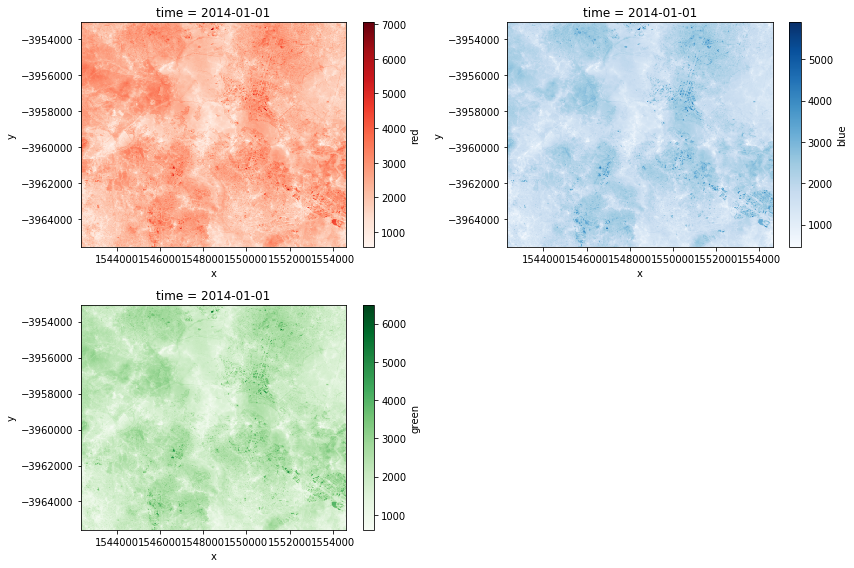

In [87]:
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

ax1=plt.subplot(gs[0,0])
ds.red.isel(time=0).plot(cmap='Reds')

ax2=plt.subplot(gs[1,0])
ds.green.isel(time=0).plot(cmap='Greens')

ax3=plt.subplot(gs[0,1])
ds.blue.isel(time=0).plot(cmap='Blues')

plt.tight_layout()
plt.show()

### Plot it as three bands

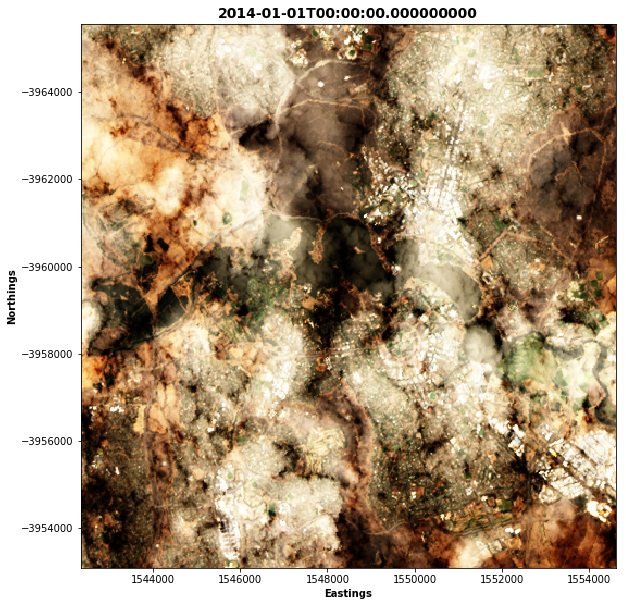

In [88]:
three_band_image(ds, bands = ['red', 'green', 'blue'], time = 0, contrast_enhance=True);

## REFERENCES

1. QGIS Org., 2018. *QGIS - A Free and Open Source Geographic Information System.* Page last updated: 2018-05-18. https://qgis.org/en/site/

2. NASA, 2003. *Panoply - netCDF Visualization Software v 1.5.1* Page created, circa 2003. https://earth.usc.edu/files/ge-labs/EdGCM/Documentation/Panoply_Manual.pdf

3. NASA, 2018. *Panoply netCDF, HDF and GRIB Data Viewer.* Page last modified: 2018-05-31 09:01 https://www.giss.nasa.gov/tools/panoply/ 

4. Scripps Institution of Oceanography, 2016. *Ncview: a netCDF visual browser*. Page last updated: 29 March, 2016. http://meteora.ucsd.edu/~pierce/ncview_home_page.html
